# Naive Wafer Detector

Naive Detector aims to process those images with a single wafer.

## Preprocessing

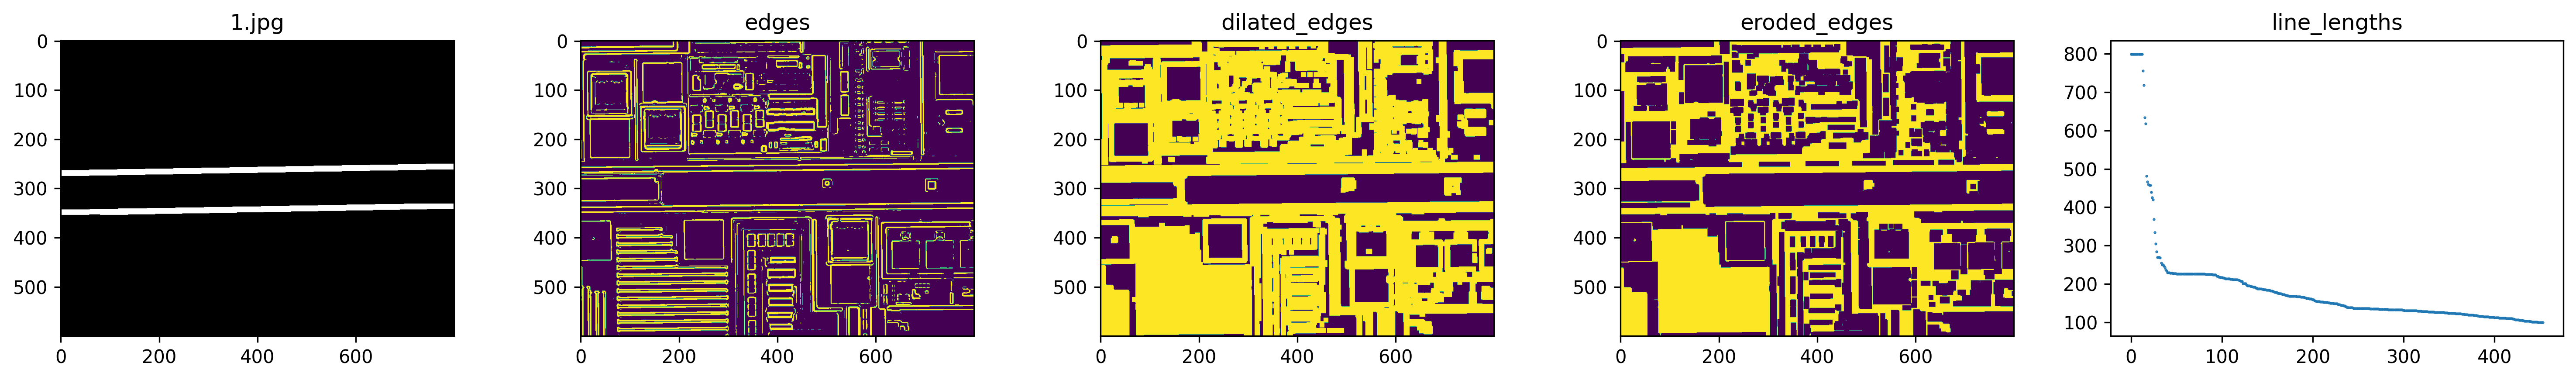

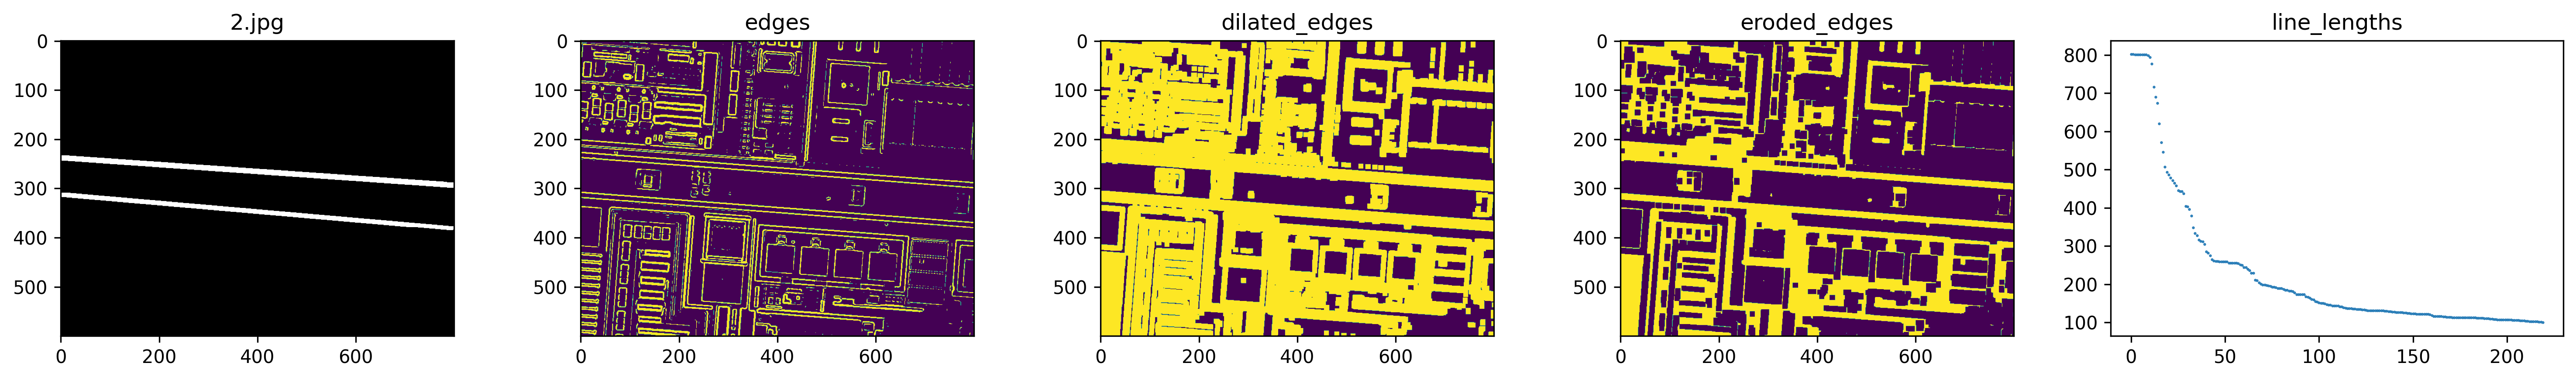

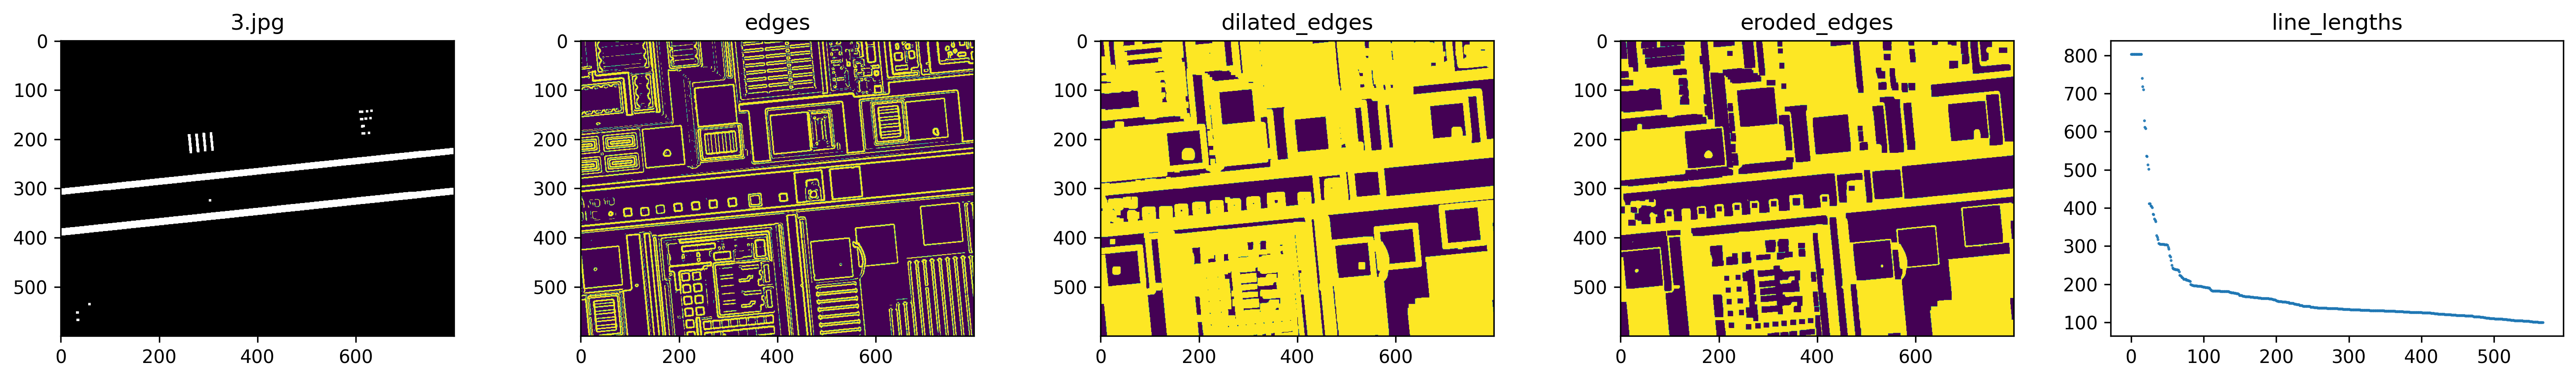

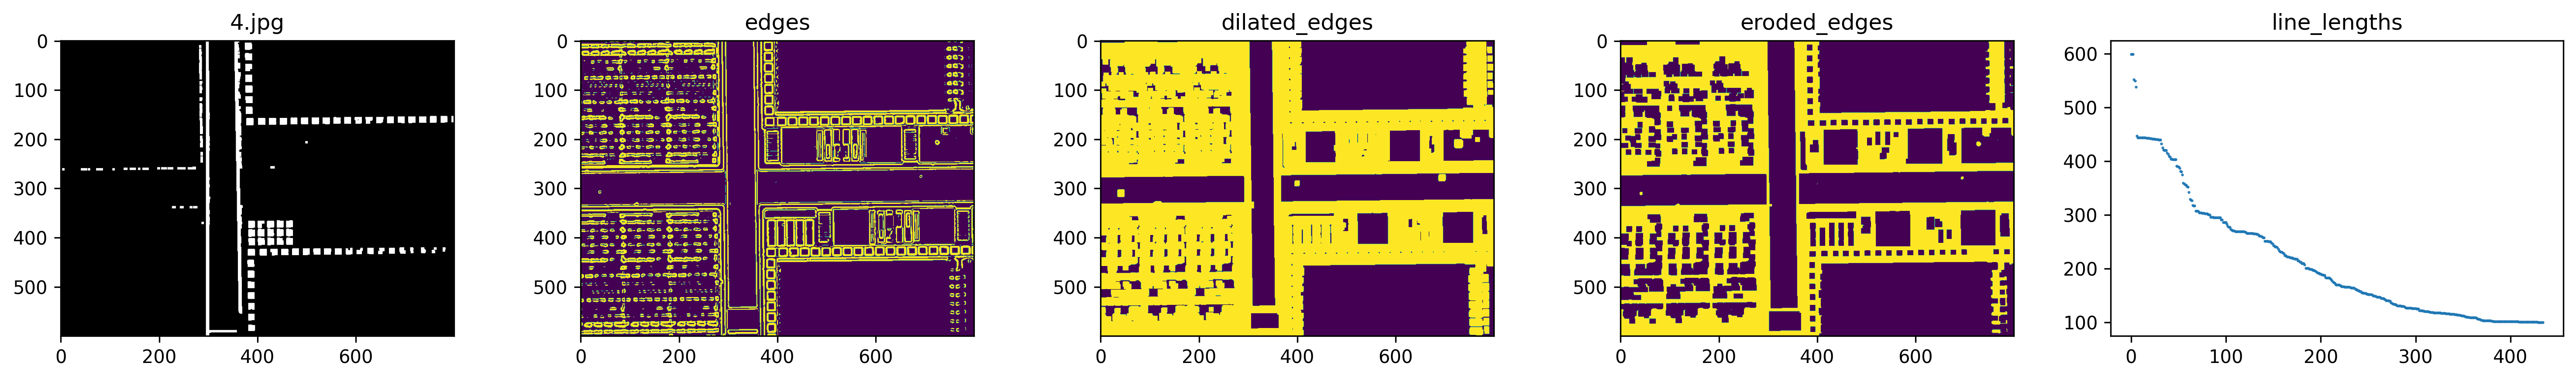

In [52]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

# edge detection using sobel filter
def edge_detection(img, threshold = 0.3, operator = 'sobel'):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = None
    if operator == 'sobel':
        # blur the image
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        # apply sobel filter
        sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)
        # combine sobelx and sobely
        sobel = np.sqrt(sobelx**2 + sobely**2)
        # normalize sobel
        sobel = sobel / np.max(sobel)
        # threshold sobel
        sobel[sobel < threshold] = 0
        sobel[sobel >= threshold] = 1
        edges = sobel
    elif operator == 'canny':
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        edges = cv2.Canny(blur, 255 * threshold * 0.4, 255 * threshold, apertureSize = 3) 
    else:
        edges = gray
    return edges

def edge_erosion(edges: cv2.Mat, size):
    # enhance using erosion
    kernel = np.ones((size, size),np.uint8)
    if size == 0:
        return edges
    erosion = cv2.erode(edges, kernel,iterations = 1)
    return erosion

def edge_dilation(edges: cv2.Mat, size):
    # enhance using dilation
    kernel = np.ones((size, size),np.uint8)
    dilation = cv2.dilate(edges, kernel,iterations = 1)
    return dilation

# line detection using hough transform
def line_detection(edges: cv2.Mat, model = "hough", **kwargs):
    # convert edges to grayscale
    gray = (edges * 255).astype(np.uint8)
    lines = None
    if model == "hough":
        # hough transform using HoughLineP
        lines = cv2.HoughLinesP(gray, 1, np.pi/180, 100, minLineLength = kwargs["minLineLength"], maxLineGap = kwargs["maxLineGap"])
    elif model == "LSD":
        # hough transform using LSD
        lsd = cv2.createLineSegmentDetector(0)
        lines = lsd.detect(gray)
    return lines

def calc_line_length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def opening(edges: cv2.Mat, size):
    # enhance using opening
    kernel = np.ones((size, size),np.uint8)
    opening = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)
    return opening

# list file names under dataset directory
import os
dataset_dir = '../dataset'
output_dir = '../mid-output'

if not os.path.exists(os.path.abspath(output_dir)):
    os.mkdir(os.path.abspath(output_dir))

file_names = os.listdir(dataset_dir)
for file_name in file_names:
    # read image
    img = cv2.imread(os.path.join(dataset_dir, file_name))
    
    # edge detection
    edges = edge_detection(img, 0.3, "sobel")
    # edges = edge_detection(img, 0.3, "canny")
    # iterate point in egdes

    # edge enhancement
    eroded_edges = edges
    for i in range(3):
        dilated_edges = edge_dilation(eroded_edges, 10)
        eroded_edges = edge_erosion(dilated_edges, 10)
    
    # lines detection
    lines = line_detection(eroded_edges, "hough", minLineLength=100, maxLineGap=10)
    
    # sort lines by their length
    lines = sorted(lines, key=lambda x: calc_line_length(x), reverse=True)
    
    # select the top lines
    top_k = 0
    line_lengths = []
    for line in lines:
        line_lengths.append(calc_line_length(line))
    
    max_length = calc_line_length(lines[0])
    error = 100
    for line in lines:
        length = calc_line_length(line)
        if length > max_length - error:
            top_k += 1
        else:
            break
    selected_lines = lines[:top_k]
    
    # iterate img to binarize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for line in selected_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), 255, 4, cv2.LINE_AA)
    
    # print(img)
    img[img != 255] = 0
    img = edge_erosion(img, 5)
    img = edge_dilation(img, 5)
    # img[img >=200] = 255

    # show images: img, edges, dilated_edges
    plt.figure(figsize=(20, 3), dpi=300)
    
    plt.subplot(1, 5, 1)
    plt.imshow(img, cmap='gray')
    plt.title(file_name)
    cv2.imwrite(os.path.join(output_dir, "processed_" + file_name), img)

    plt.subplot(1, 5, 2)
    plt.imshow(edges)
    plt.title("edges")
    
    plt.subplot(1, 5, 3)
    plt.imshow(dilated_edges)
    plt.title("dilated_edges")
    
    plt.subplot(1, 5, 4)
    plt.imshow(eroded_edges)
    plt.title("eroded_edges")
    
    plt.subplot(1, 5, 5)
    plt.plot(line_lengths, 'o', markersize=0.5)
    plt.title("line_lengths")
    
    plt.tight_layout()
    plt.show()



## Processing

processed_1.jpg
angle: 1.0°


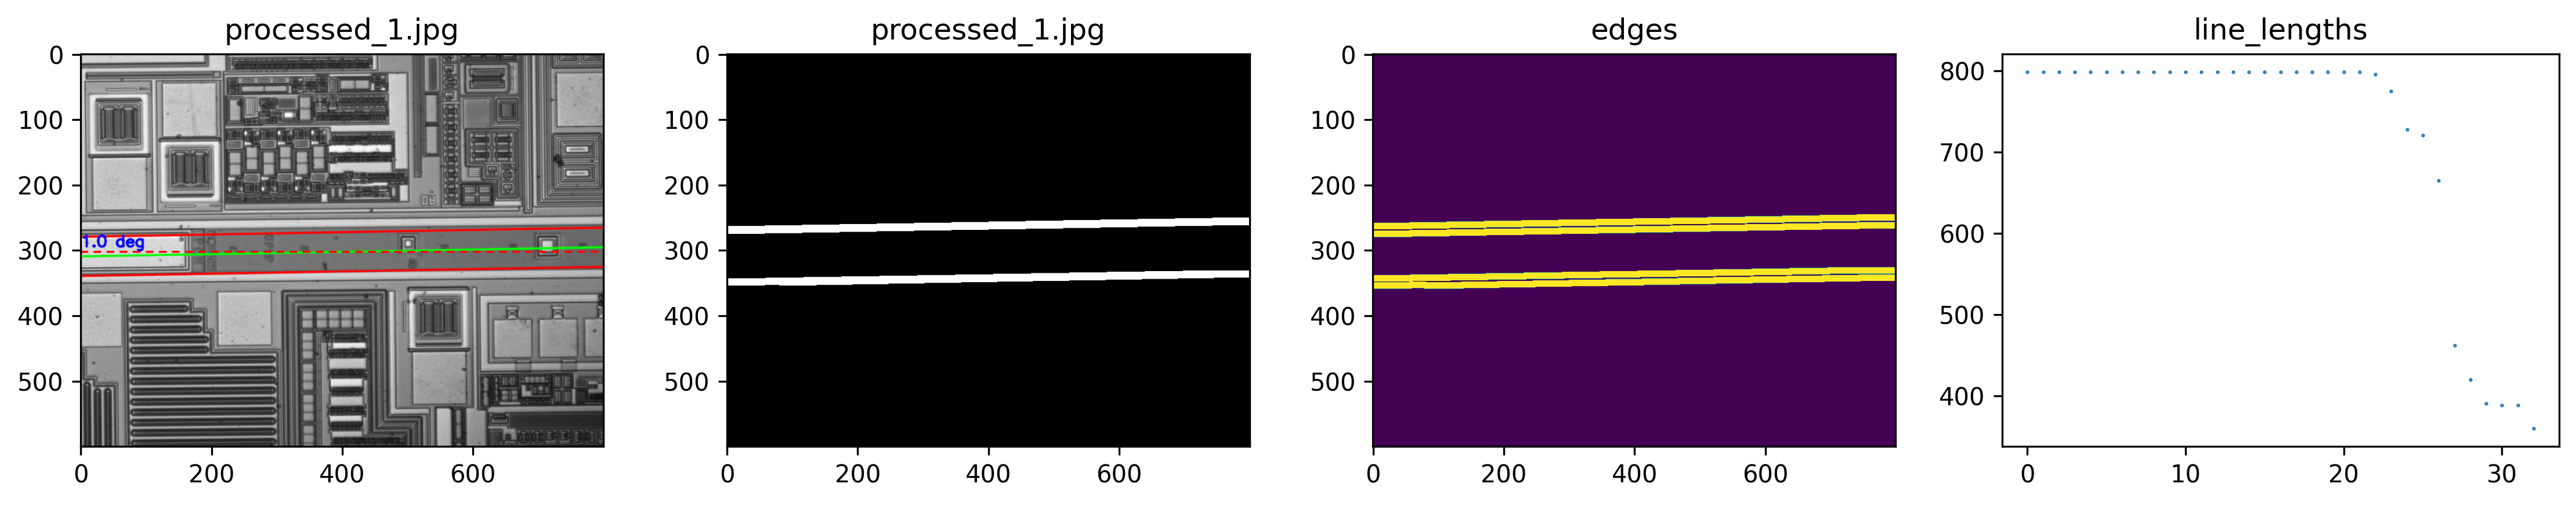

processed_2.jpg
angle: -4.51°


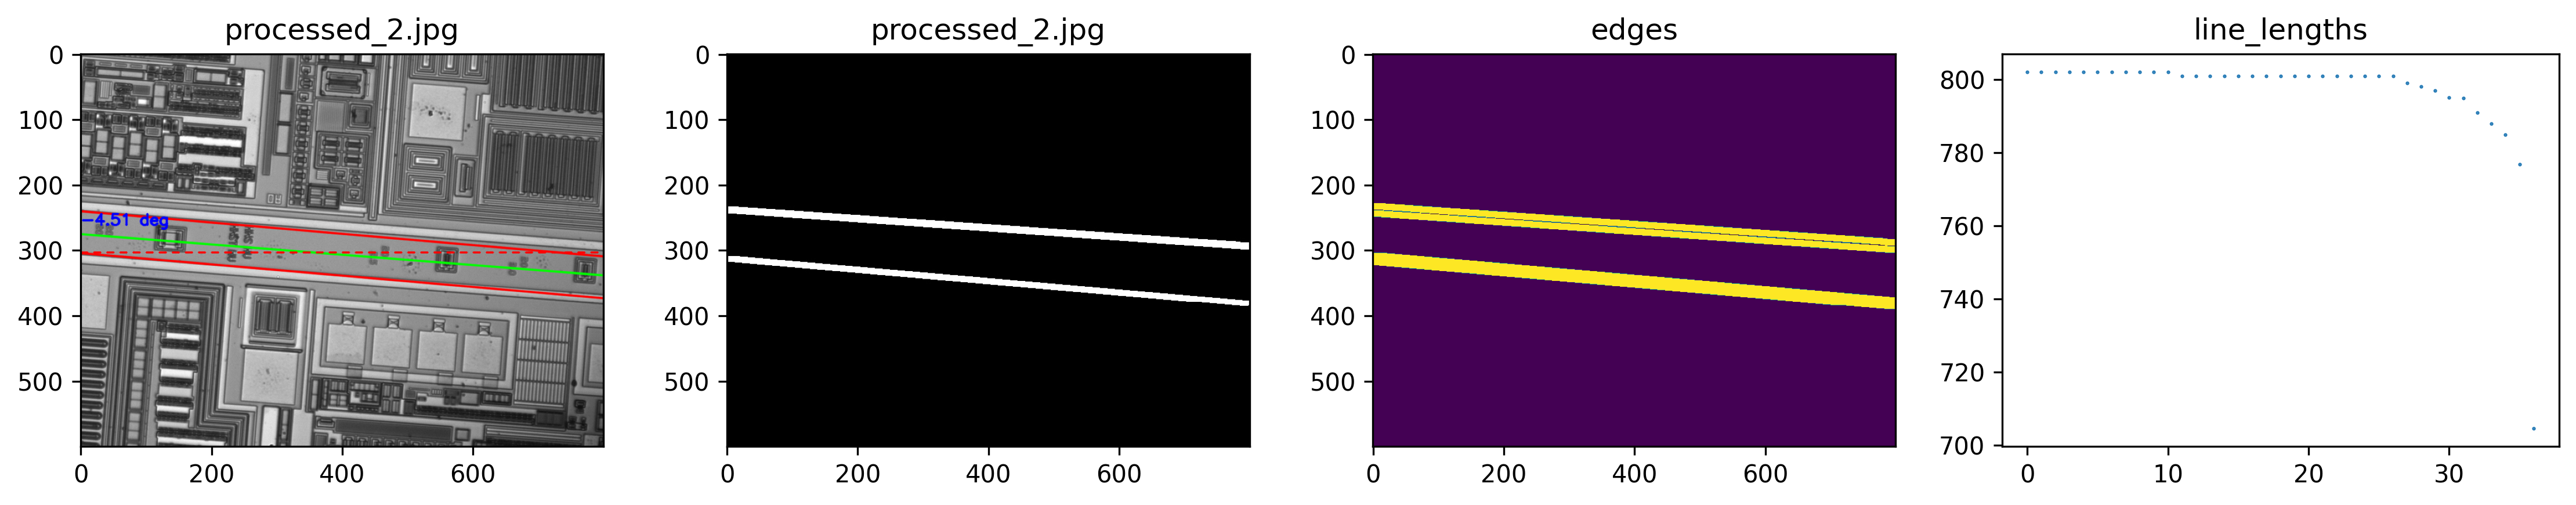

processed_3.jpg
angle: 6.0°


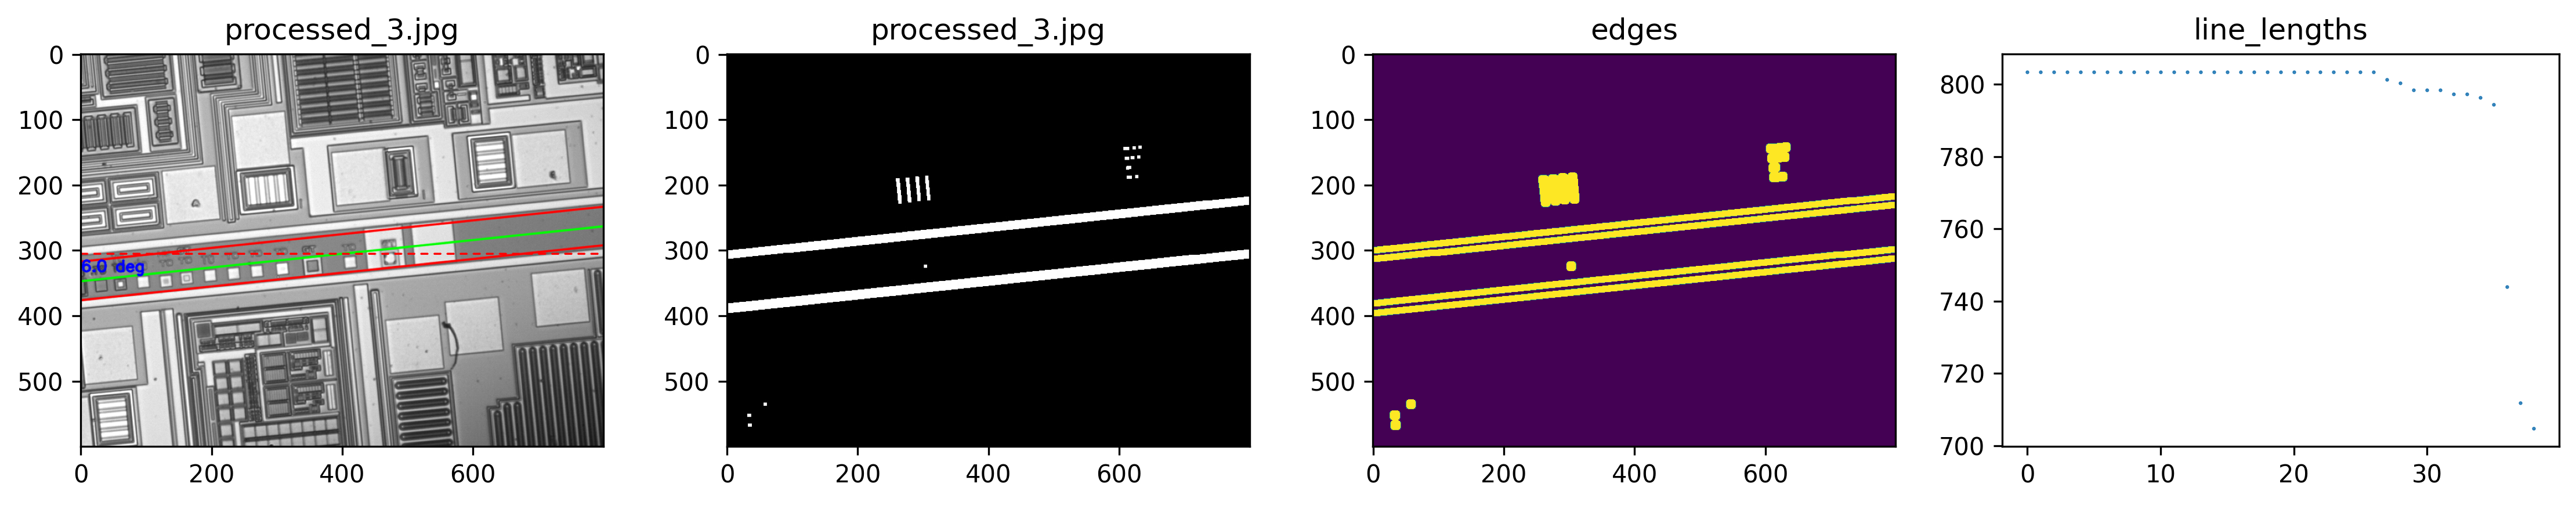

processed_4.jpg
angle: -89.04°


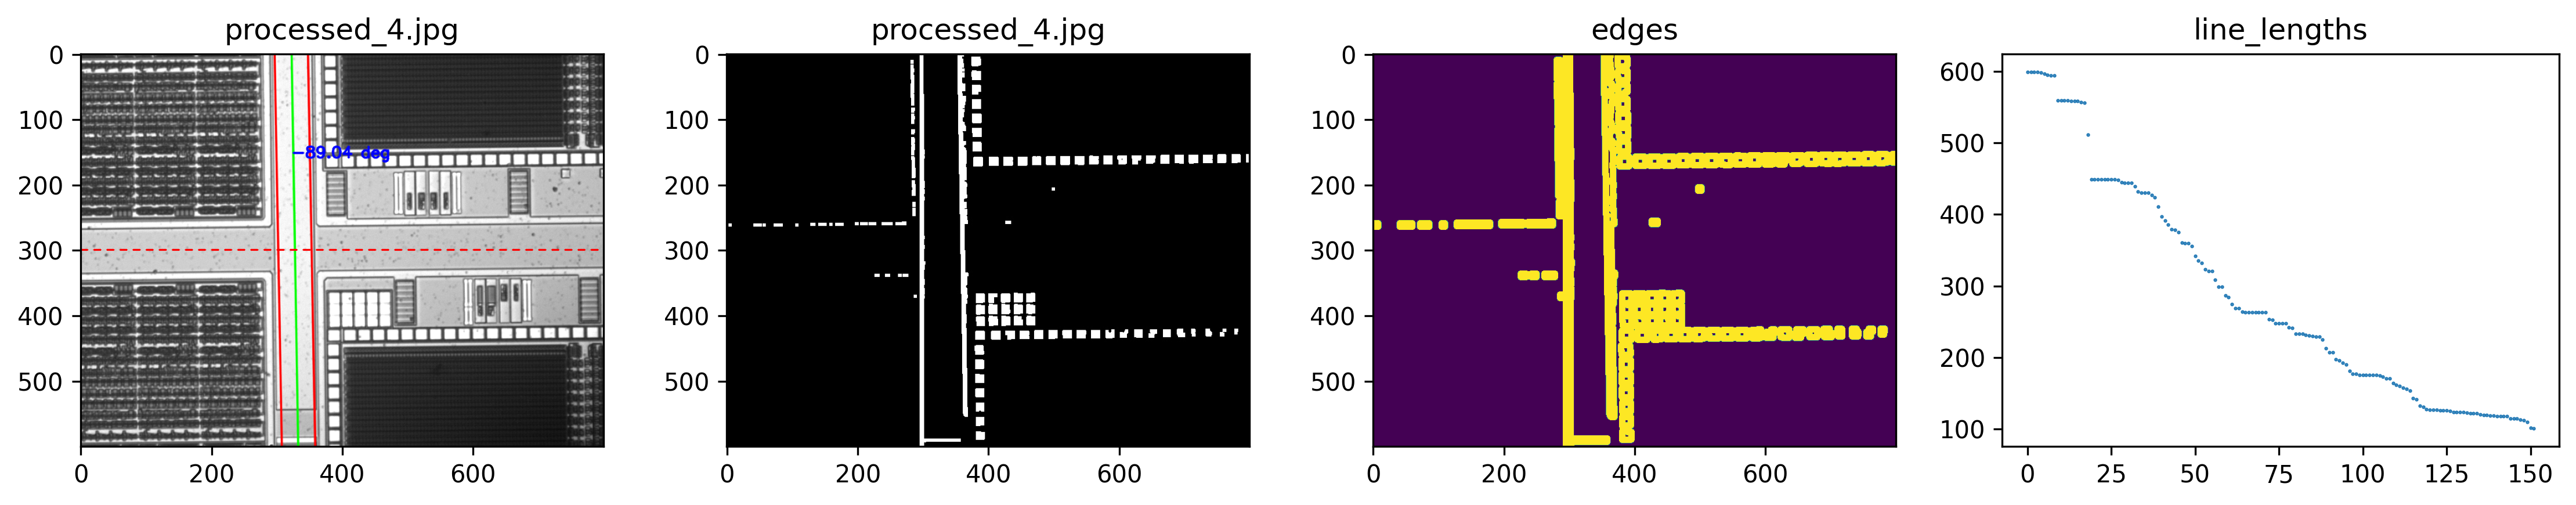

In [64]:
def get_line_center(line):
    x1, y1, x2, y2 = line[0]
    return (int((x1 + x2) / 2), int((y1 + y2) / 2))

def get_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def cv2_drawline(img,pt1,pt2,color,thickness=1,style='dotted',gap=20): 
    dist =((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)**.5 
    pts= [] 
    for i in np.arange(0,dist,gap): 
        r=i/dist 
        x=int((pt1[0]*(1-r)+pt2[0]*r)+.5) 
        y=int((pt1[1]*(1-r)+pt2[1]*r)+.5) 
        p = (x,y) 
        pts.append(p) 
 
    if style=='dotted': 
        for p in pts: 
            cv2.circle(img,p,thickness,color,-1) 
    else: 
        s=pts[0] 
        e=pts[0] 
        i=0 
        for p in pts: 
            s=e 
            e=p 
            if i%2==1: 
                cv2.line(img,s,e,color,thickness) 
            i+=1 

import os

dataset_dir= '../dataset'
midput_dir = '../mid-output'
output_dir = '../output'

if not os.path.exists(os.path.abspath(output_dir)):
    os.mkdir(os.path.abspath(output_dir))

orig_file_names = os.listdir(dataset_dir)
file_names = os.listdir(midput_dir)
for fid, file_name in enumerate(file_names):
    print(file_name)
    # read image
    img = cv2.imread(os.path.join(midput_dir, file_name))
    
    # edge detection
    edges = edge_detection(img, 0.1, "sobel")
    edges = edge_dilation(edges, 5)
    # lines detection
    lines = line_detection(edges, "hough", minLineLength=100, maxLineGap=10)
    
    # sort lines by their length
    lines = sorted(lines, key=lambda x: calc_line_length(x), reverse=True)
    
    # select the top lines
    error = 50
    top_k = 0
    line_lengths = []
    for line in lines:
        line_lengths.append(calc_line_length(line))
    max_length = calc_line_length(lines[0])
    for line in lines:
        length = calc_line_length(line)
        if length > max_length - error:
            top_k += 1
        else:
            break
    selected_lines = lines[:top_k]

    # group lines
    least_gap = 50
    one_sides = []
    other_sides = []
    one_sides.append(selected_lines[0])
    one_side_center = get_line_center(selected_lines[0])
    for i in range(1, len(selected_lines)):
        line = selected_lines[i]
        center = get_line_center(line)
        if get_distance(center, one_side_center) < least_gap:
            one_sides.append(line)
        else:
            other_sides.append(line)
            
    # choose two closest lines from each side
    min_gap = 1000
    for one_side_line in one_sides:
        for other_side_line in other_sides:
            one_side_center = get_line_center(one_side_line)
            other_side_center = get_line_center(other_side_line)
            gap = get_distance(one_side_center, other_side_center)
            if gap < min_gap:
                min_gap = gap
                selected_one_side_line = one_side_line
                selected_other_side_line = other_side_line

    orig_img = cv2.imread(os.path.join(dataset_dir, orig_file_names[fid]))
    # fine-grained adjustment

    # determine the direction of the line
    x1, y1, x2, y2 = selected_one_side_line[0]
    angle = np.rad2deg(np.arctan2(y1 - y2,  x2 - x1))
    if abs(angle) < 45:
        # horizontal
        x1 = min(selected_one_side_line[0][0], selected_other_side_line[0][0])
        x2 = max(selected_one_side_line[0][2], selected_other_side_line[0][2])
        selected_one_side_line[0][0] = x1
        selected_one_side_line[0][2] = x2
        selected_other_side_line[0][0] = x1
        selected_other_side_line[0][2] = x2 

        x1, y1, x2, y2 = selected_one_side_line[0]
        cv2.line(orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2, cv2.LINE_AA)
        k = (y2 - y1) / (x2 - x1)
        x1, y1, x2, y2 = selected_other_side_line[0]
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
        y1 = int(k * (x1 - center[0]) + center[1])
        y2 = int(k * (x2 - center[0]) + center[1])
        cv2.line(orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2, cv2.LINE_AA)

        # draw lines
        if selected_other_side_line[0][1] > selected_one_side_line[0][1]:
            upper_edge = selected_one_side_line
            lower_edge = selected_other_side_line
        else:
            upper_edge = selected_other_side_line
            lower_edge = selected_one_side_line
        lower_x1, lower_y1, lower_x2, lower_y2 = lower_edge[0]
        upper_x1, upper_y1, upper_x2, upper_y2 = upper_edge[0]
        saw_line = [[lower_x1, (lower_y1 + upper_y1) // 2, upper_x2, (lower_y2 + upper_y2) // 2]]
        saw_x1, saw_y1, saw_x2, saw_y2 = saw_line[0]
        cv2.line(orig_img, (saw_x1, saw_y1), (saw_x2, saw_y2), (0, 255, 0), 2, cv2.LINE_AA)
        # draw a horizontal line
        cv2_drawline(orig_img, (lower_x1, (lower_y1 + upper_y2) // 2), (upper_x2, (lower_y1 + upper_y2) // 2), (255, 0, 0), 2, style="dashed", gap=10)
        
        # calc angle in degrees
        angle = np.rad2deg(np.arctan2(saw_y1 - saw_y2,  saw_x2 - saw_x1))
        print("angle: " + str(round(angle, 2)) + "°")
        cv2.putText(orig_img, str(round(angle, 2)) + " deg", (saw_x1, (saw_y1 + upper_y1) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        # vertical
        y1 = min(selected_one_side_line[0][1], selected_other_side_line[0][1])
        y2 = max(selected_one_side_line[0][3], selected_other_side_line[0][3])
        selected_one_side_line[0][1] = y1
        selected_one_side_line[0][3] = y2
        selected_other_side_line[0][1] = y1
        selected_other_side_line[0][3] = y2

        x1, y1, x2, y2 = selected_one_side_line[0]
        cv2.line(orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2, cv2.LINE_AA)
        k = (x2 - x1) / (y2 - y1)
        x1, y1, x2, y2 = selected_other_side_line[0]
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
        x1 = int(k * (y1 - center[1]) + center[0])
        x2 = int(k * (y2 - center[1]) + center[0])
        cv2.line(orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2, cv2.LINE_AA)

        # draw lines
        if selected_other_side_line[0][0] > selected_one_side_line[0][0]:
            left_edge = selected_one_side_line
            right_edge = selected_other_side_line
        else:
            left_edge = selected_other_side_line
            right_edge = selected_one_side_line
        left_x1, left_y1, left_x2, left_y2 = left_edge[0]
        right_x1, right_y1, right_x2, right_y2 = right_edge[0]
        saw_line = [[(left_x1 + right_x1) // 2, left_y1, (left_x2 + right_x2) // 2, right_y2]]
        saw_x1, saw_y1, saw_x2, saw_y2 = saw_line[0]
        cv2.line(orig_img, (saw_x1, saw_y1), (saw_x2, saw_y2), (0, 255, 0), 2, cv2.LINE_AA)
        # draw a horizontal line
        cv2_drawline(orig_img, (0, (left_y1 + right_y2) // 2), (orig_img.shape[1], (left_y1 + right_y2) // 2), (255, 0, 0), 2, style="dashed", gap=10)
        # calc angle in degrees
        angle = np.rad2deg(np.arctan2(saw_y1 - saw_y2,  saw_x2 - saw_x1))
        print("angle: " + str(round(angle, 2)) + "°")
        cv2.putText(orig_img, str(round(angle, 2)) + " deg", (saw_x1, (saw_y1 + upper_y1) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
    
    
    # show images: img, edges, dilated_edges
    plt.figure(figsize=(15, 3), dpi=300)
    
    plt.subplot(1, 4, 1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(file_name)
    cv2.imwrite(os.path.join(output_dir, "final_" + file_name), orig_img)
    
    plt.subplot(1, 4, 2)
    plt.imshow(img, cmap='gray')
    plt.title(file_name)

    plt.subplot(1, 4, 3)
    plt.imshow(edges)
    plt.title("edges")
    
    plt.subplot(1, 4, 4)
    plt.plot(line_lengths, 'o', markersize=0.5)
    plt.title("line_lengths")
    
    plt.tight_layout()
    plt.show()